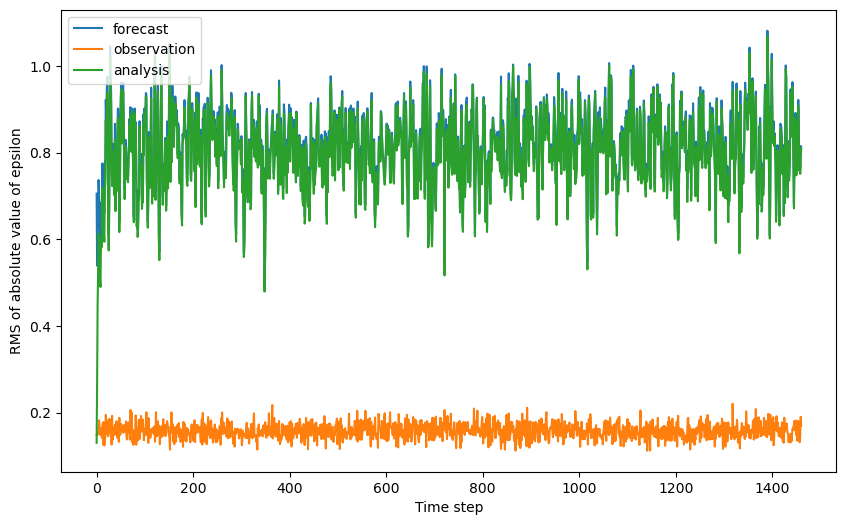

In [21]:
import pandas as pd
import numpy as np
from scipy.linalg import inv, sqrtm
from numpy import identity as eye
import matplotlib.pyplot as plt

F = 8.0
N = 40
dt = 0.05
days = 365
day_steps = int(0.20 / dt)  
time_step = days * day_steps + 1
delta = 1.0e-5
ls_time_step = [i for i in range(time_step)]

def L96(x):
    dxdt = np.zeros(N)
    for i in range(N):
        dxdt[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return dxdt

def Rk4(xold):
    k1 = L96(xold)
    k2 = L96(xold + k1 * dt / 2.)
    k3 = L96(xold + k2 * dt / 2.)
    k4 = L96(xold + k3 * dt)
    xnew = xold + dt / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    return xnew

#Root-Mean-Square
def RMS(error):
    RSS = 0
    for i in range(len(error)):
        RSS += error[i]**2
    return (np.sqrt(RSS))/len(error)

def main():
    df_x_true = pd.read_csv('true_data.csv', header=0, index_col=0)
    x_true = df_x_true.values
    df_y = pd.read_csv('observed_data.csv', header=0, index_col=0)
    y = df_y.values
    #ヤコビ行列での計算で使う
    IN = np.eye(N)
    #観測演算子(今回は y : 40変数、x : 40変数)
    #仮
    H = np.eye(N)
    #観測誤差共分散行列(標準正規分布に従う乱数を真値に足して観測データとした)
    #仮
    R = np.eye(N)
    #初期設定
    #仮(真値と１ステップだけずらした)
    x_a = x_true[:,1]
    epsilon_a = x_a - x_true[:,0]
    #解析誤差共分散行列
    temp = []
    Pa = np.eye(N)
    #モニター用の配列
    #予報誤差
    error_f = []
    #観測誤差
    error_o = []
    #解析誤差
    error_a = []
    for i in range(N):
        temp.append(epsilon_a[i]**2)
        Pa[i,i] = temp[i]
        
    for i in range(time_step):
        x_f = Rk4(x_a)
        JM = np.zeros((N, N))
        for j in range(N):
            JM[:, j] = (Rk4(x_a + delta * IN[:,j]) - Rk4(x_a)) / delta

        Pf = JM @ Pa @ JM.T
        K = Pf @ H.T @ inv(H @ Pf @ H.T + R)
        x_a = x_f + K @ (y[:, i] - H @ x_f)
        Pa = (eye(N) - K @ H) @ Pf
        
        error_f.append(RMS(x_f - x_true[:, i]))
        error_o.append(RMS(y[:,i] - x_true[:, i]))
        error_a.append(RMS(x_a - x_true[:, i]))
        
    plt.figure(figsize=(10, 6))
    plt.xlabel('Time step')
    plt.ylabel('RMS of absolute value of epsilon')
    plt.plot(ls_time_step, error_f, label='forecast')
    plt.plot(ls_time_step, error_o, label='observation')
    plt.plot(ls_time_step, error_a, label='analysis')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
